In [2]:
import numpy as np
import pandas as pd
import json
import random
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

### Query by commitee

In [3]:
class Parse:
    def __init__(self):
        self.X_unlabeled = np.loadtxt(path_unlabeled)
        
    def _save_labeled(self, X, y):
        with open(path_labeled, 'a') as ifile:
            for i, x in enumerate(X):
                ifile.write(str(y[i]) + ' ' + ' '.join(np.array(x).astype('str')) + '\n')
            
    def _save_unlabeled(self):
        np.savetxt(path_unlabeled, self.X_unlabeled, fmt='%.15f')
        
    def _link(self, X):
        answers = []
        for x in X:
            url = 'https://oraclets6208571042618710905.appspot.com/oracle?x1=' + \
                str(x[0]) + '&x2=' + str(x[1]) + '&x3=' + str(x[2]) + '&x4=' + str(x[3]) + '&x5=' + str(x[4]) + \
                '&x6=' + str(x[5]) + '&x7=' + str(x[6]) + '&x8=' + str(x[7]) + '&x9=' + str(x[8]) + '&x10=' + str(x[9])
            response = float(requests.get(url).content.decode().split()[3])
            answers.append(response)
        return answers
            
    def get_target(self, id_new):
        X = self.X_unlabeled[id_new]
        target_new = self._link(X)
        self._save_labeled(X, target_new)
        self.X_unlabeled = np.delete(self.X_unlabeled, id_new, axis=0)
        self._save_unlabeled()
        return target_new
            
    def get_unlabeled(self):
        return self.X_unlabeled   

In [4]:
class ActiveLearning:
    def __init__(self, X, y, n=200):
        self.X = X
        self.y = y
        self.n = n
        
    def _update(self):
        X = np.concatenate(([self.X, self.X_new]), axis=0)
        y = np.concatenate(([self.y, self.y_new]), axis=0)
        return X, y
        
    def query(self):
        X_unlabeled = parse.get_unlabeled()
        n_algoritms = 10
        step = len(self.X) / n_algoritms
        predicts = []
        for i in range(n_algoritms):
            model.fit(self.X[int(i*step):int((i+1)*step)], self.y[int(i*step):int((i+1)*step)])
            predicts.append(model.predict(X_unlabeled))
        
        mean_predicts = np.mean(np.array(predicts), axis=0)
        diff = sum((predicts - mean_predicts)**2)
        answer = list(zip(diff, range(len(X_unlabeled))))
        answer = sorted(answer, key=lambda x: x[0], reverse=True)
        id_new = [idx for a, idx in answer[:self.n]]
        self.X_new = X_unlabeled[id_new]
        self.y_new = parse.get_target(id_new)
        return self._update()

In [5]:
class RandomSampling:
    def __init__(self, X, y, n=10):
        self.X = X
        self.y = y
        self.n = n
        
    def _update(self):
        X = np.concatenate(([self.X, self.X_new]), axis=0)
        y = np.concatenate(([self.y, self.y_new]), axis=0)
        return X, y
    
    def query(self):
        X_unlabeled = parse.get_unlabeled()
        id_new = random.sample(range(0, X_unlabeled.shape[0]), self.n)
        self.X_new = X_unlabeled[id_new]
        self.y_new = parse.get_target(id_new)
        return self._update()

In [6]:
def get_test():
    test_data  = np.loadtxt(path_test)
    X_test = test_data[:, 1:]
    y_test = test_data[:, 0]
    return X_test, y_test

def get_valid():
    valid_data  = np.loadtxt(path_valid)
    X_valid = valid_data[:, 1:]
    y_valid = valid_data[:, 0]
    return X_valid, y_valid

def get_train():
    X_train = []
    y_train = []
    train_data = np.loadtxt(path_train)
    if len(train_data) > 0:
        X_train = train_data[:, 1:]
        y_train = train_data[:, 0]

    train_data = np.loadtxt(path_labeled)
    if len(train_data) > 0:
        X_train = np.concatenate(([X_train, train_data[:, 1:]]), axis=0)
        y_train = np.concatenate(([y_train, train_data[:, 0]]), axis=0)
        
    return X_train, y_train

def create_random(n):
    data = 10 * np.random.random_sample((n, 10))
    np.savetxt(path_unlabeled, data, fmt='%.15f')
    
def save_files(loss, train_size):
    with open(path_loss, 'a') as ifile:
        for i, l in enumerate(loss):
            ifile.write(str(loss[i]) + '\n')
            
    with open(path_size, 'a') as ifile:
        for i, t in enumerate(train_size):
            ifile.write(str(train_size[i]) + '\n')

In [7]:
def eActive(X_train, y_train):
    isRandom = np.random.binomial(1, 0.01)
    if isRandom == 1:
        random_sampling = RandomSampling(X_train, y_train)
        X_train, y_train = random_sampling.query()
    else:
        active_learning = ActiveLearning(X_train, y_train)
        X_train, y_train = active_learning.query()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    loss.append(rmse)
    size.append(X_train.shape[0])
    return X_train, y_train

In [8]:
model = XGBRegressor(n_estimators=200, subsample=0.2, max_depth=4, learning_rate=0.1, nthread=-1)

In [9]:
path_unlabeled = './data/unlabeled.txt'
path_labeled = './data/labeled.txt'
path_train = './data/train.txt'
path_test = './data/test.txt'
path_valid = './data/valid.txt'
path_loss = './data/loss.txt'
path_size = './data/size.txt'
loss = list(np.loadtxt(path_loss))
size = list(np.loadtxt(path_size))
X_test, y_test = get_test()

In [10]:
# Создаем начальный рандомный train
# n_train = 100
# create_random(n_train)
# parse = Parse() 
# parse.get_target(list(range(n_train)))

# Создаем test
# n_test = 30000
# create_random(n_test)
# parse = Parse() 
# parse.get_target(list(range(n_test)))

In [108]:
%%time
n_iter = 50
for i in tqdm_notebook(range(n_iter), total=n_iter, mininterval=1):
    n_unlabeled = 5000
    create_random(n_unlabeled)
    parse = Parse() 
    X_train, y_train = get_train()
    X_train, y_train = eActive(X_train, y_train) # отберет 200 худших примеров из unlabeled
    np.savetxt(path_unlabeled, [])
    # save_files(loss, size)

In [39]:
def get_allTrain():
    X_train = []
    y_train = []
    train_data = np.loadtxt('./data/train.txt')
    if len(train_data) > 0:
        X_train = train_data[:, 1:]
        y_train = train_data[:, 0]

    train_data = np.loadtxt('./data/labeled.txt')
    if len(train_data) > 0:
        X_train = np.concatenate(([X_train, train_data[:, 1:]]), axis=0)
        y_train = np.concatenate(([y_train, train_data[:, 0]]), axis=0)
        
    train_data = np.loadtxt('./data/test.txt')
    if len(train_data) > 0:
        X_train = np.concatenate(([X_train, train_data[:, 1:]]), axis=0)
        y_train = np.concatenate(([y_train, train_data[:, 0]]), axis=0)
        
    train_data = np.loadtxt('./data/valid.txt')
    if len(train_data) > 0:
        X_train = np.concatenate(([X_train, train_data[:, 1:]]), axis=0)
        y_train = np.concatenate(([y_train, train_data[:, 0]]), axis=0)
        
    return X_train, y_train

In [40]:
X_train, y_train = get_allTrain()

In [86]:
X_privat  = np.loadtxt('./privat/data')
X_privat.shape

(2000000, 10)

In [89]:
%%time
model = XGBRegressor(n_estimators=1500, subsample=0.2, max_depth=4, learning_rate=0.1, nthread=-1)
model.fit(X_train, y_train)
y_privat = model.predict(X_privat)

CPU times: user 12min, sys: 2.52 s, total: 12min 2s
Wall time: 12min 6s


In [92]:
df = pd.DataFrame({"Id": list(range(1, len(y_privat)+1)), "Expected": y_privat})
df.to_csv('./predict.csv', sep=',', index=False)

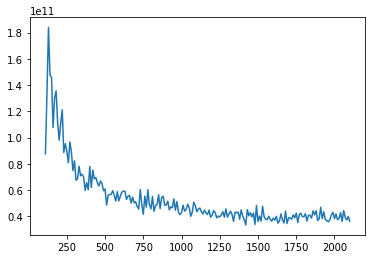

In [18]:
plt.plot(train_size, loss)
plt.show()